In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="x5a2b-better_base_edge_recycling", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="free", id="x5a2c-free_edge", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="decaylength", id="x5a2d-decaylength", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="edgerecycling", id="x5a2e-edge_recycling", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="pump", id="x5a2g-pump_targetfrec_1.0", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])


CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]


# Convergence

base


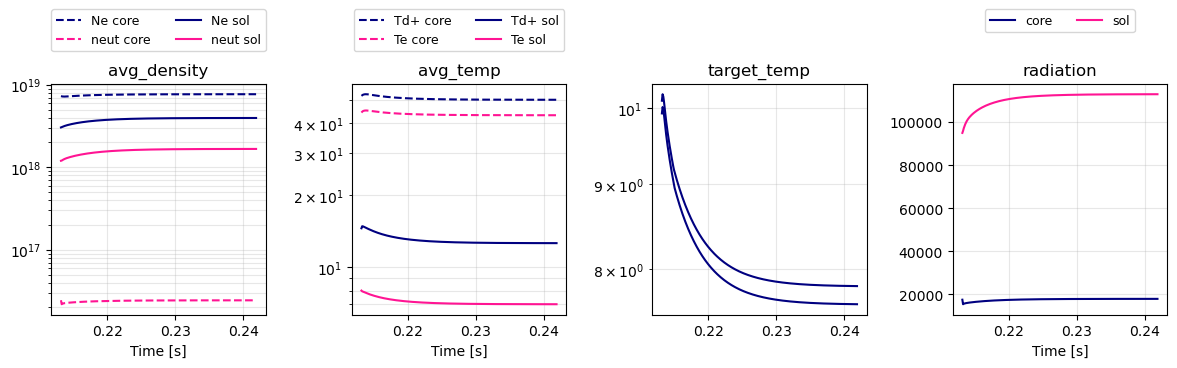

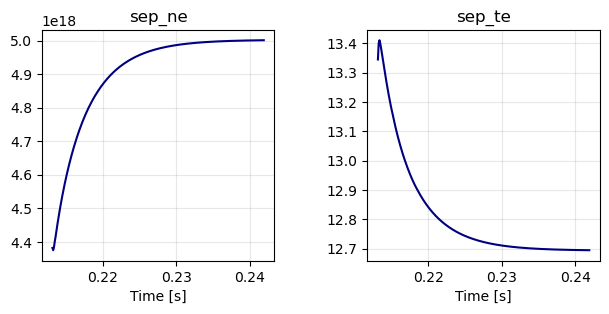

In [4]:
for casename in casestore.keys():
    print(casename)
    Monitor(casestore[casename], [["avg_density", "avg_temp", "target_temp","radiation"],
                                  ["sep_ne", "sep_te"]
                ])

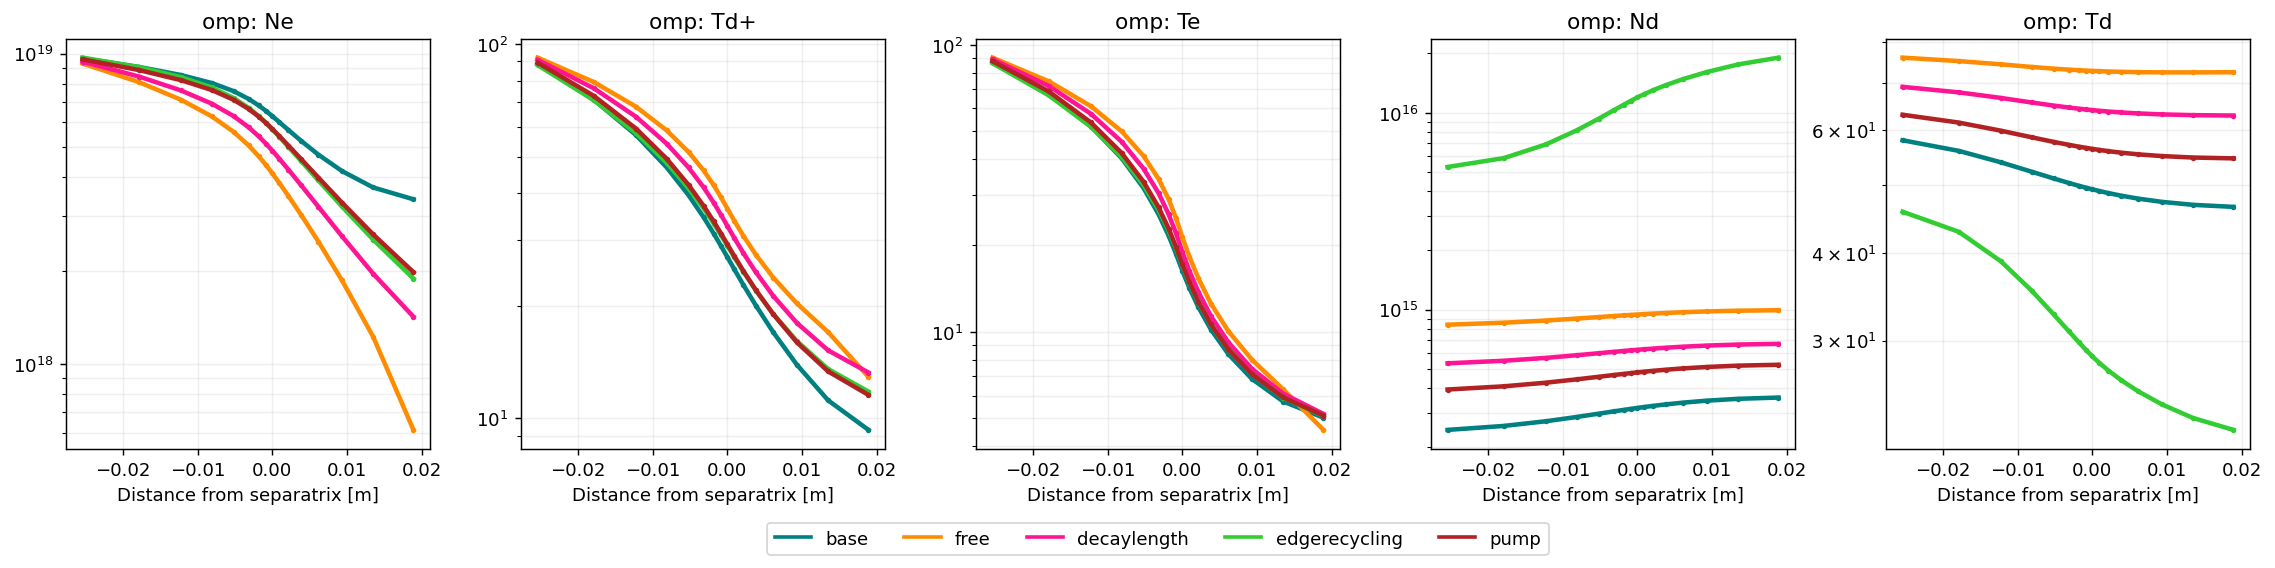

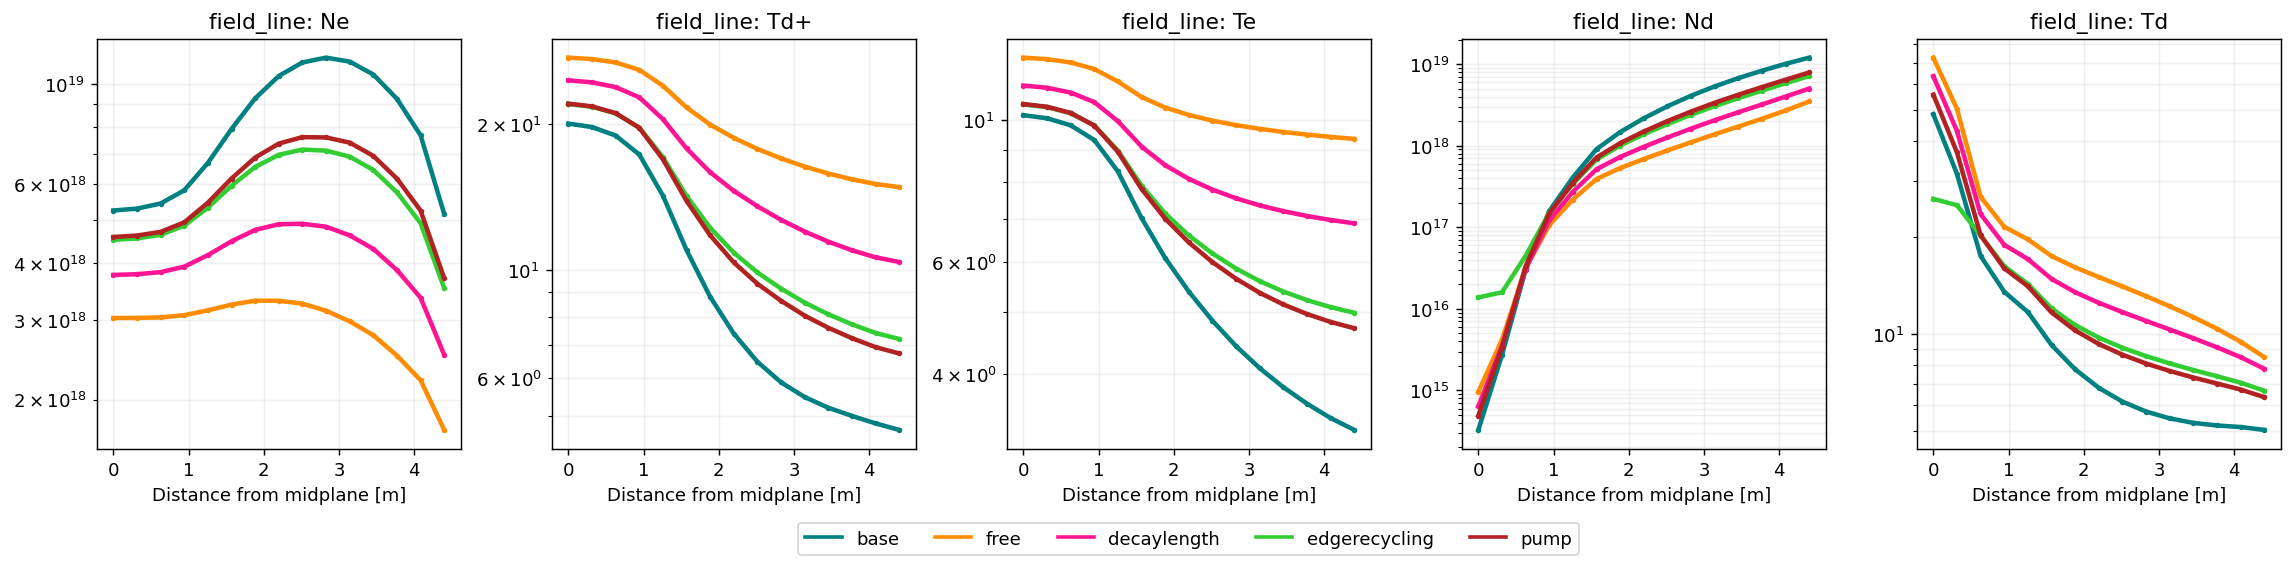

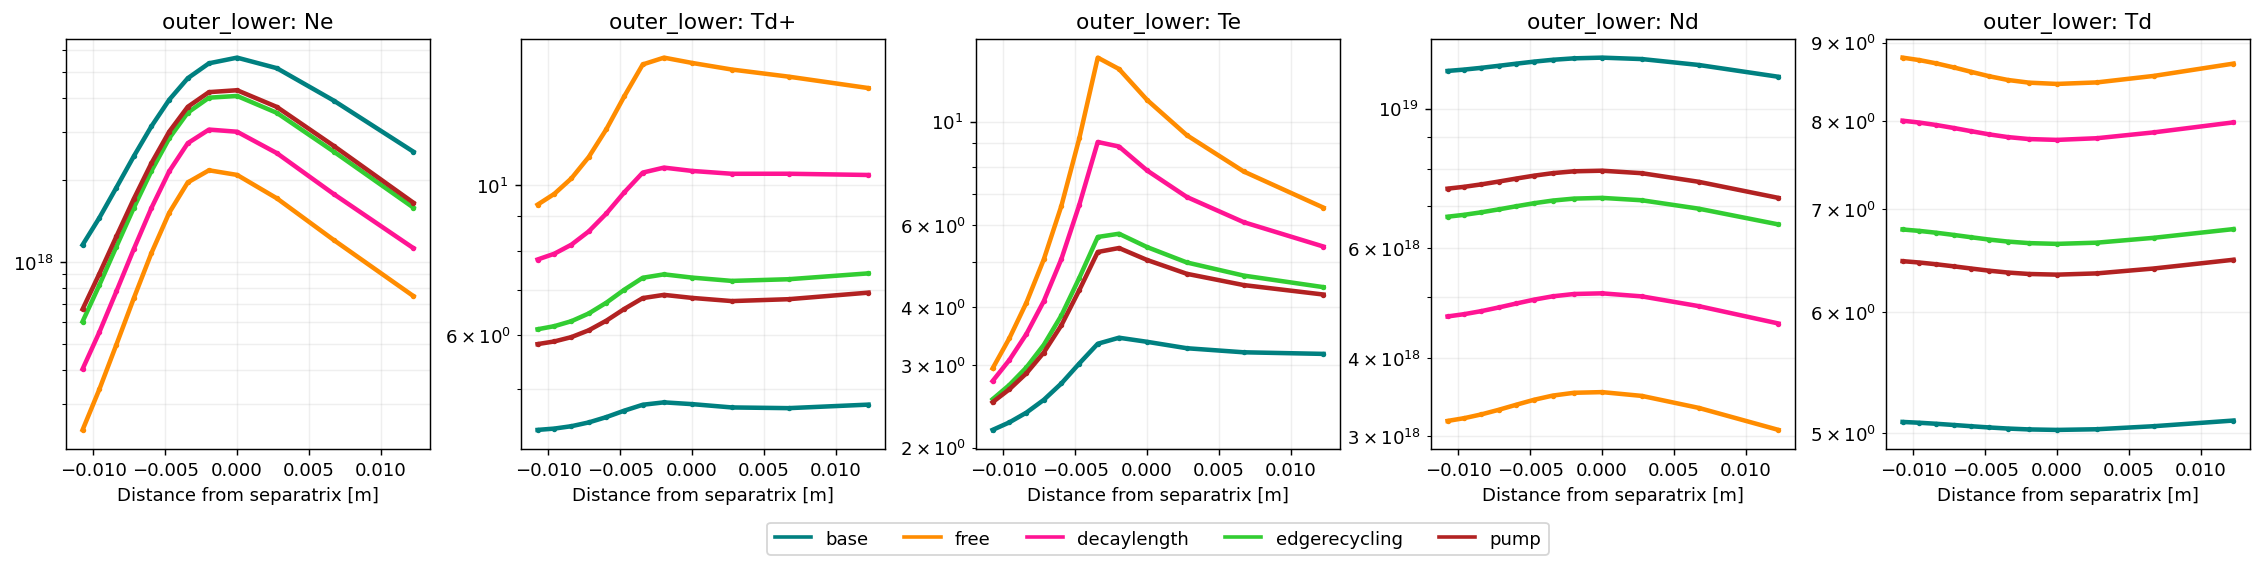

In [4]:
cases = dict()

for name in ["base", "free", "decaylength", "edgerecycling", "pump"]:
    cases[name] = casestore[name].ds.isel(t=-1, x = slice(2,-2))


lineplot(
    cases = cases,
    clean_guards = False,
    regions = ["omp", "field_line", "outer_lower"],
    params = ["Ne", "Td+", "Te", "Nd", "Td"],
    # params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
    dpi = 130
)

### 2D plot

(-0.87, 0.0)

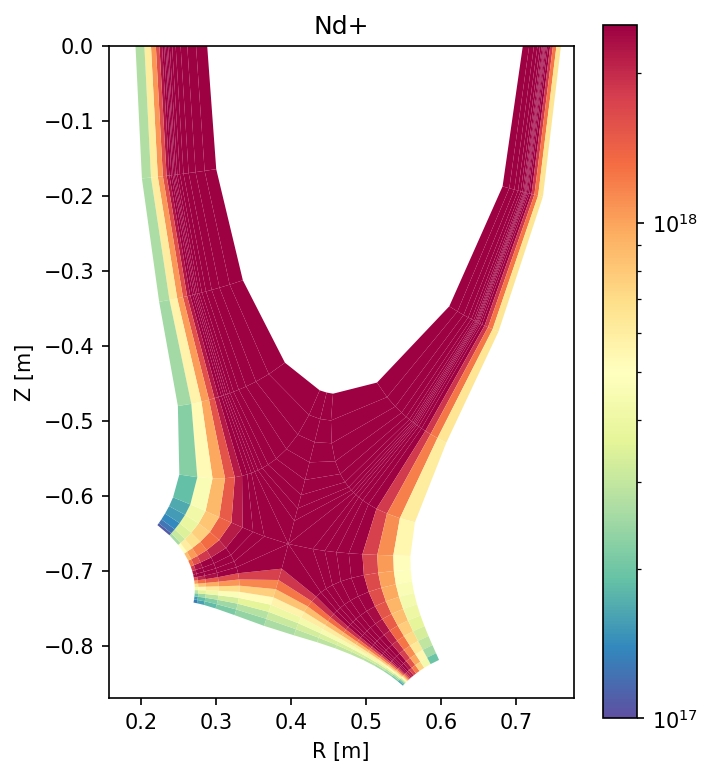

In [ ]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
# (ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e4, vmax = 1e4, logscale = True)
(ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True, vmin = 0.1e18, vmax = 2.5e18)

ax.set_aspect("equal")
ax.set_ylim(-0.87, 0)

In [28]:
pfr_edge["Sd_pfr_recycle"].shape

(1, 19)

In [ ]:
pfr = ds.hermesm.select_region("lower_pfr")

# plot_selection(ds, pfr)

fig, ax = plt.subplots()
pfr["Ne"].plot(ax = ax, log = True)

# SOL edge gradients

Text(0.5, 1.0, '(last - guard)/last (+ve = out of domain)')

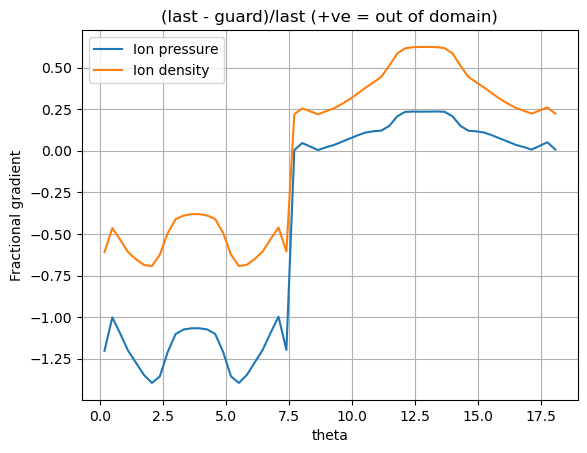

In [19]:
((ds["Pd+"].isel(x=-3) - ds["Pd+"].isel(x=-2)) /  ds["Pd+"].isel(x=-3)).plot(label = "Ion pressure")
((ds["Nd+"].isel(x=-3) - ds["Nd+"].isel(x=-2)) /  ds["Nd+"].isel(x=-3)).plot(label = "Ion density")
# (ds["Pd+"].isel(x=-2) *-1).plot(label = "recycle")
# (ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm).plot(label = "flux")
plt.legend()
plt.grid()
plt.ylabel("Fractional gradient")
plt.title("(last - guard)/last (+ve = out of domain)")
# ds["Sd_target_recycle"].isel(x=-3).plot()

In [ ]:
plot_selection(ds, domain_noy)

In [7]:
domain_noy.isel(x=-2)["ParticleFlow_d+_xlow"].values.sum() * nfluxnorm

-7.384019150539778e+19

In [8]:
domain_noy.isel(x=-2)["ParticleFlow_d+_xlow"].values.sum() * nfluxnorm * (3 * constants("q_e"))

-35.49150853388127

In [10]:
species = "d+"
core_flux = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values
sol_flux = sol_guards[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values * -1
pfr_flux = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values
target_flux = ds["pf_int_targets_d+"].values
recycle_flux = (domain["Sd_target_recycle"]* (m["Nnorm"] * m["Omega_ci"]) * domain["dv"]).sum().values 

print(f"Core flux: {core_flux:.2e}")
print(f"SOL flux: {sol_flux:.2e}")
print(f"PFR flux: {pfr_flux:.2e}")
print(f"Target flux: {target_flux:.2e}")
print(f"Recycle flux: {recycle_flux:.2e}")

Core flux: 2.25e+20
SOL flux: -7.38e+19
PFR flux: 0.00e+00
Target flux: -3.05e+21
Recycle flux: 2.73e+21


In [46]:
ds["pf_int_targets_d+"].values[0]

-3.050598318477588e+21

In [39]:
frecycle = 0.95
total = 0
for loc in ["inner_lower_target", "inner_upper_target", "outer_upper_target", "outer_lower_target"]:
    target = ds.hermesm.select_region(loc)
    recycle_source = (target["Sd_src_recycle"] * (m["Nnorm"] * m["Omega_ci"] * target["dv"])).sum().values 
    total += recycle_source 
    print(f"{loc}: {recycle_source:.2e}")
    

print(f"Recycle flux: {total:.2e}")

inner_lower_target: 3.57e+20
inner_upper_target: 3.58e+20
outer_upper_target: 1.09e+21
outer_lower_target: 1.09e+21
Recycle flux: 2.90e+21


# Post-processing

## 2D plots

In [10]:
%matplotlib inline

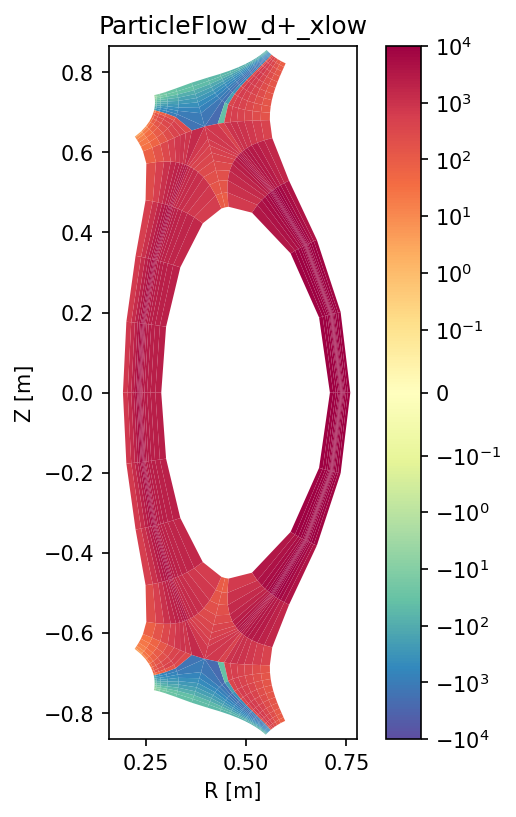

In [12]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
(ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e4, vmax = 1e4, logscale = True)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True)

ax.set_aspect("equal")
# ax.set_ylim(-0.87, 0)

## Lineplots

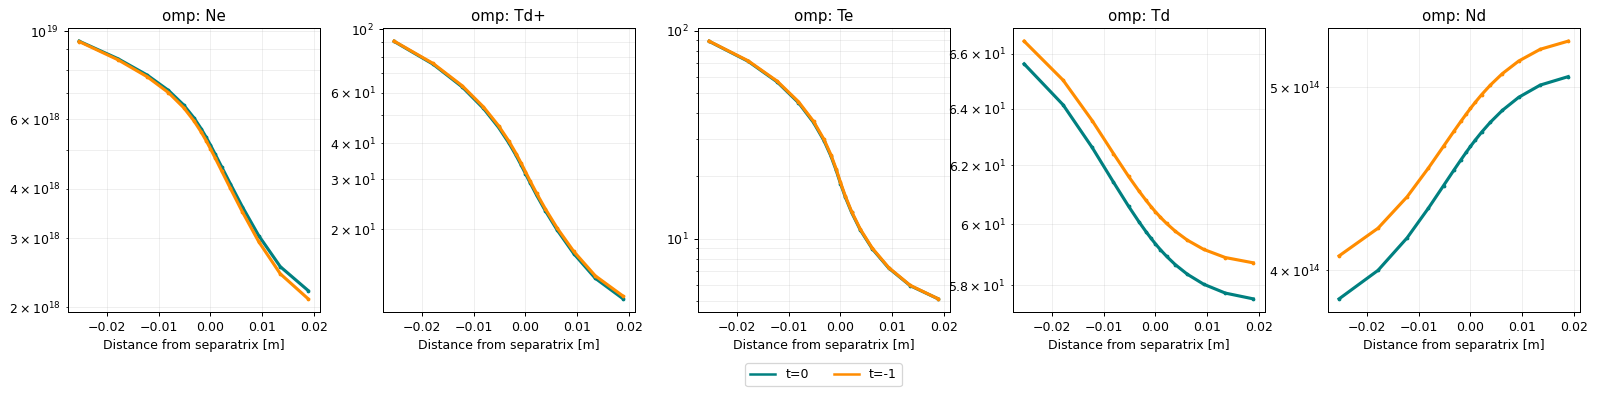

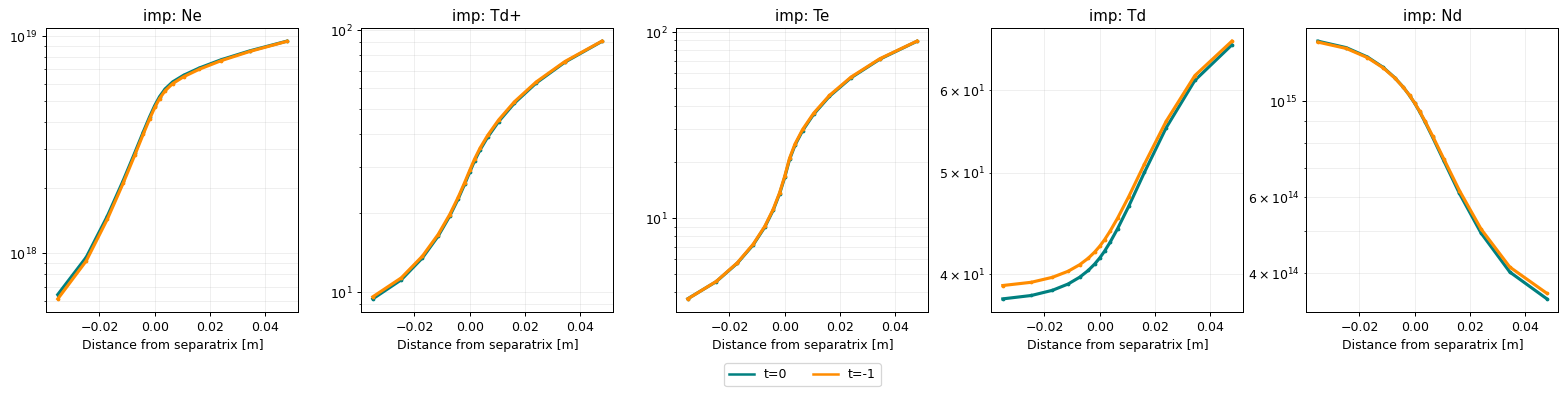

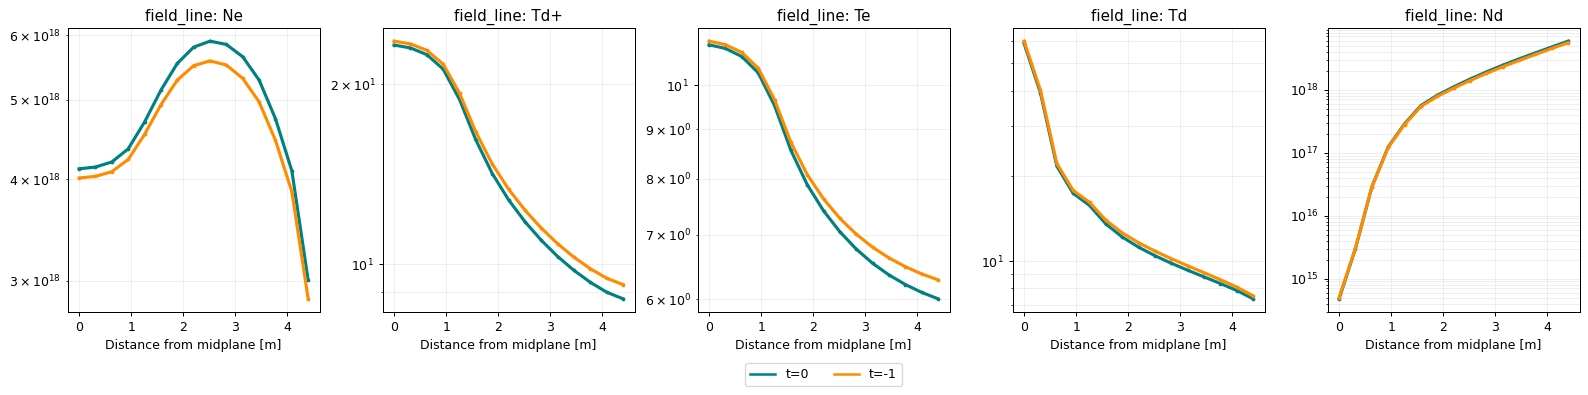

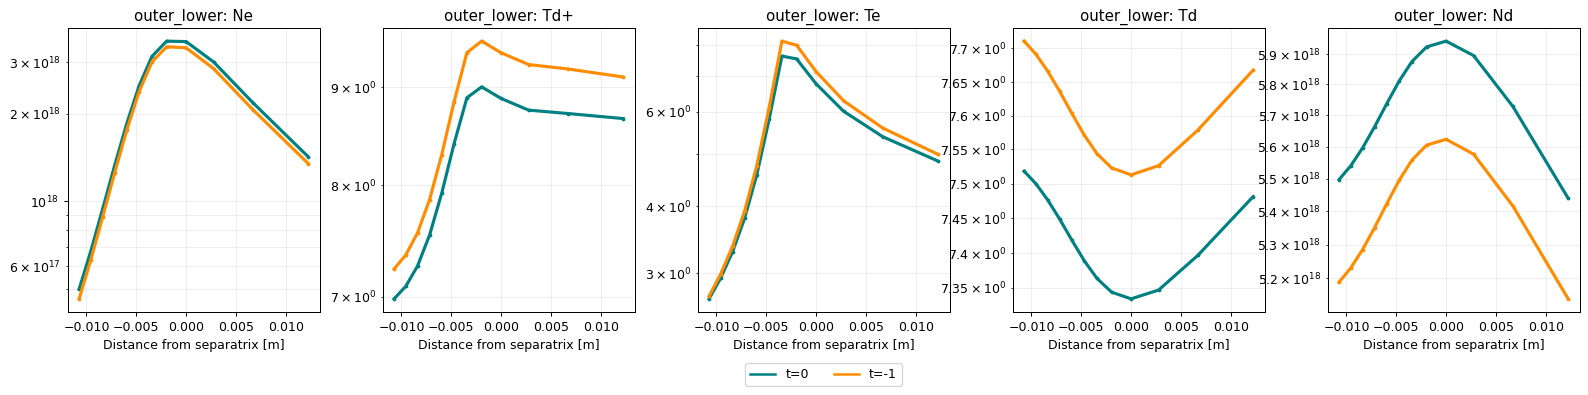

In [11]:
cases = dict()

cases["t=0"] = casestore["base"].ds.isel(t=0, x = slice(2,-2))
cases["t=-1"] = casestore["base"].ds.isel(t=-1, x = slice(2,-2))

lineplot(
    cases = cases,
    clean_guards = False,
    regions = ["omp", "imp", "field_line", "outer_lower"],
    params = ["Ne", "Td+", "Te", "Td", "Nd"],
    # params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
    dpi = 90
)

# 2D comparison

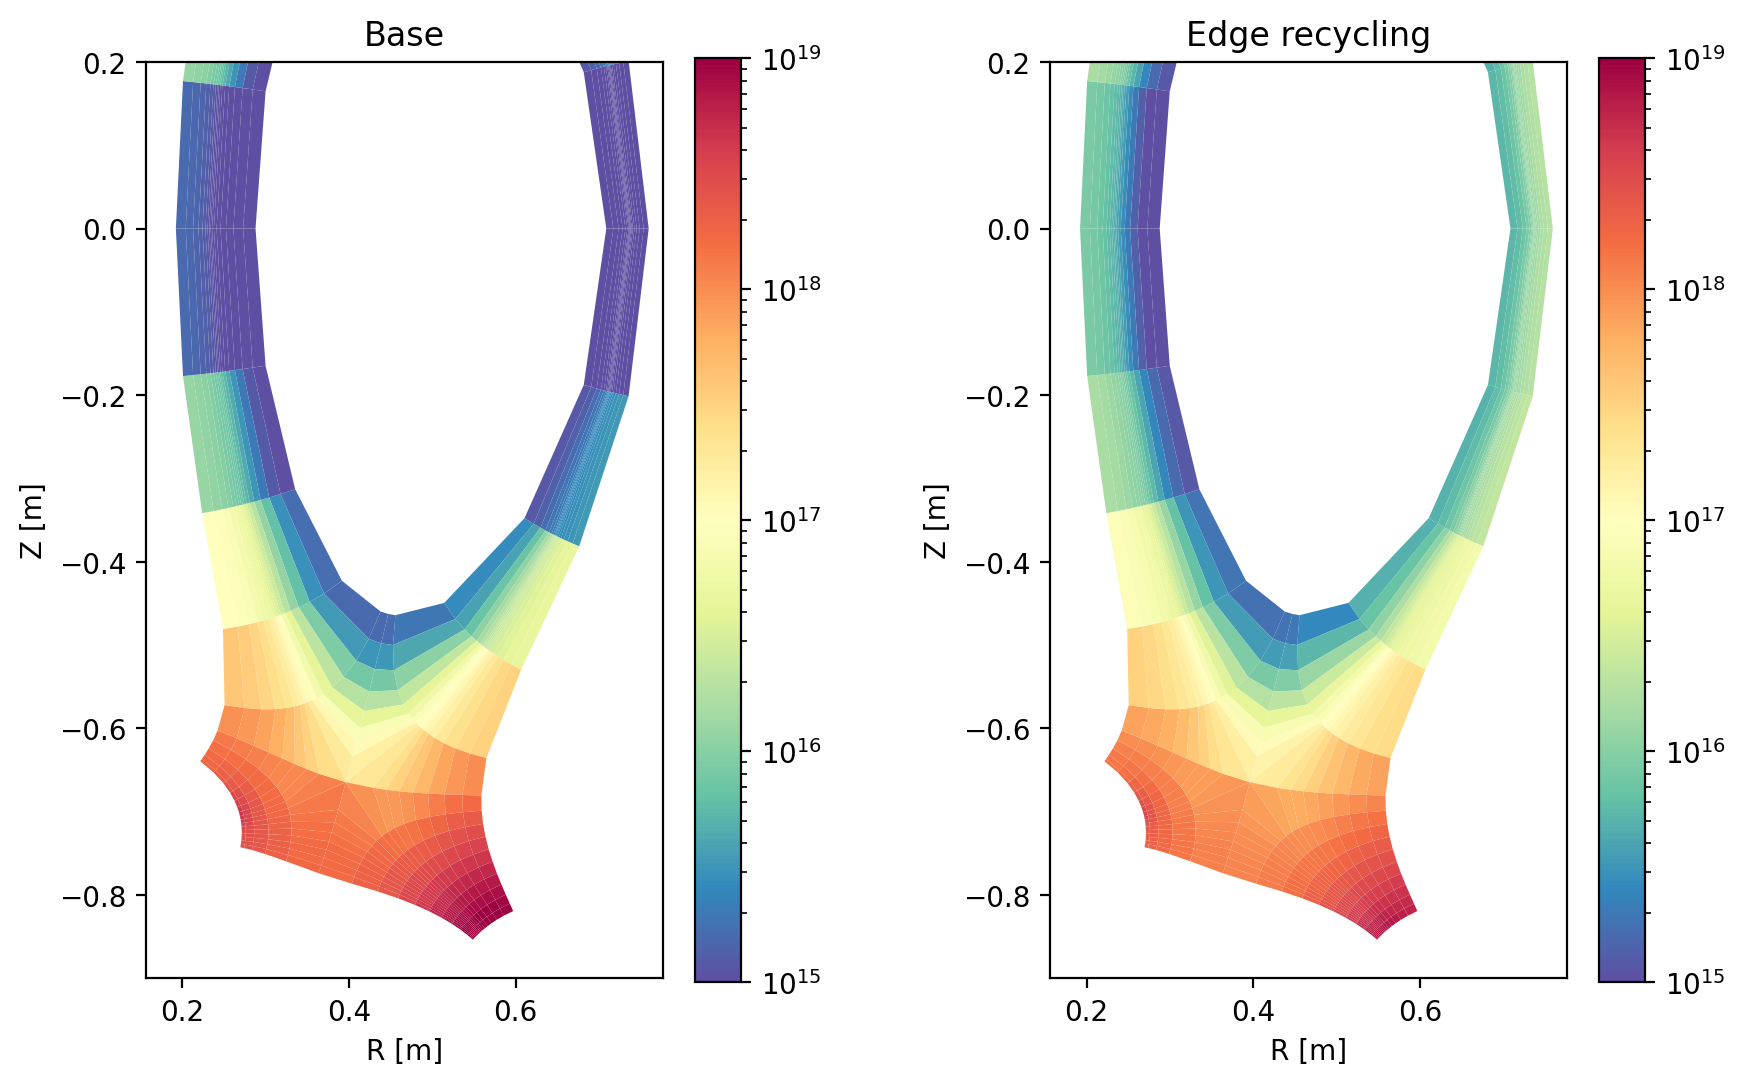

In [20]:
fig, axes = plt.subplots( 1, 2, dpi = 200, figsize = (10,6))

fig.subplots_adjust(wspace=0.4)

max = 1e19
min = 1e15
ax = axes[0]
ds = casestore["base"].ds.isel(t=-1)
(ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = ax, antialias = True, vmin = min, vmax = max, cmap = "Spectral_r", logscale = True)

ax = axes[1]
ds = casestore["edgerecycling"].ds.isel(t=-1)
(ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = ax, antialias = True, vmin = min, vmax = max, cmap = "Spectral_r", logscale = True)

ax.set_aspect("equal")

axes[0].set_title("Base")
axes[1].set_title("Edge recycling")

for ax in axes:
    ax.set_ylim(-0.9, 0.2)